# DI 725 - Project Phase 2

In [2]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-inj0lryg
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-inj0lryg
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import numpy as np
import pandas as pd
import kagglehub
import torch
from transformers import PaliGemmaForConditionalGeneration, PaliGemmaProcessor
import io
import requests
import numpy as np
import PIL
from pathlib import Path
!pip install -q sentence-transformers
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
import clip
from PIL import Image
import matplotlib.pyplot as plt
import random

In [5]:
import wandb
wandb.login(key="0e48c15605abf65402208cd05becaa061bf0dfbf")

wandb.init(
    project="vlm_for_image_captioning",
    name="phase2",
    config={
        "max_tokens": 100,
        "temperature": 0.8,
        "top_p": 0.9,
        "peft_strategy": "adapter",
        "batch_size": 4
    }
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: esrasekerci (esrasekerci-metu-middle-east-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [6]:
data_dir = Path("/kaggle/input/di725-dataset")
image_dir = data_dir / "resized"
caption_file = data_dir / "captions.csv"

model_path = "/kaggle/input/paligemma-2/transformers/paligemma2-3b-pt-224/1"
output_csv_path = "/kaggle/working/generated_captions.csv"

You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 

You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
df = pd.read_csv(caption_file)
df.head()

,source,split,image,caption_1,caption_2,caption_3,caption_4,caption_5
0,NWPU,test,NWPU_31430.jpg,A gray plane on the runway and the lawn beside .,A grey plane is on the runway by the lawn .,There is an airplane on the runway with a larg...,A plane is parked on the runway next to the gr...,There is a plane on the runway beside the grass .
1,NWPU,test,NWPU_31431.jpg,Three small planes parked in a line on the air...,"There are four aircraft on the open ground, Th...",There are many planes of different sizes in a ...,Four planes are parked on the runway .,Four planes of different sizes were on the mar...
2,NWPU,test,NWPU_31432.jpg,A plane parked in a line on the airport with s...,A white plane was parked on the instruction li...,An airplane parked in an open area with many c...,A plane is parked on the open space .,There is 1 plane on the ground marked .
3,NWPU,test,NWPU_31433.jpg,A small plane and a big plane parked next to b...,A white plane and a gray plane parked at the b...,Two planes of different sizes are neatly parke...,A large plane and a small plane are parked nea...,Two planes are on the marked ground .
4,NWPU,test,NWPU_31434.jpg,Two planes parked next to boarding bridges .,Two aircraft were parked at the departure gates .,Two planes of different sizes are neatly parke...,Two planes are parked next to the terminal .,Two planes are on the marked ground .


In [8]:
clip_model, preprocess = clip.load("ViT-B/32")

def clip_best_caption(image_path, captions):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to("cuda")
    text = clip.tokenize(captions).to("cuda")

    with torch.no_grad():
        image_features = clip_model.encode_image(image)
        text_features = clip_model.encode_text(text)
        sims = (image_features @ text_features.T).squeeze()

    return captions[sims.argmax().item()]

100%|███████████████████████████████████████| 338M/338M [00:24<00:00, 14.3MiB/s]


In [9]:
results = []

for idx, row in df.head(10).iterrows():
    img_path = image_dir / row['image']
    captions = [row[f"caption_{i}"] for i in range(1, 6)]
    best_caption = clip_best_caption(str(img_path), captions)
    
    results.append({
        "image": row['image'],
        "best_caption": best_caption
    })

best_df = pd.DataFrame(results)
best_df.head()

,image,best_caption
0,NWPU_31430.jpg,There is an airplane on the runway with a larg...
1,NWPU_31431.jpg,"There are four aircraft on the open ground, Th..."
2,NWPU_31432.jpg,There is 1 plane on the ground marked .
3,NWPU_31433.jpg,Two planes are on the marked ground .
4,NWPU_31434.jpg,Two planes are on the marked ground .


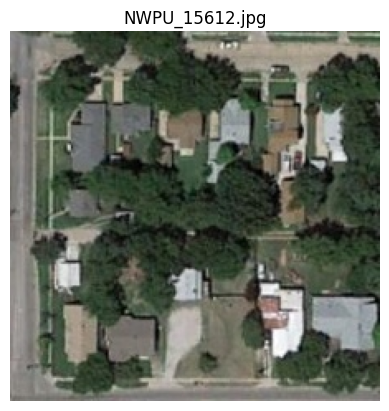

Human-written Captions:
  1. The medium residential area with some dense houses and trees is surrounded by roads .
  2. Mid-sized housing estates are run-down .
  3. The medium residential is on the grass next to some trees and road .
  4. Many trees are in medium residential area .
  5. There are some green trees and buildings on the medium residential area .

CLIP-selected Best Caption:
  Mid-sized housing estates are run-down .

----------------------------------------------------------------------------------------------------


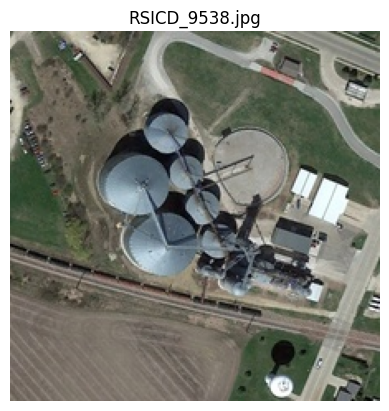

Human-written Captions:
  1. there are some big gray columnar tanks linking to each other by pipes
  2. six storage tanks are linked at the top of cone roofs near a railway and some roads .
  3. six storage tanks are linked at the top of cone roofs near a railway and some roads .
  4. these tanks are linked above next to the bare land and this road .
  5. several silver gray storage tanks are near several pieces of green meadows .

CLIP-selected Best Caption:
  several silver gray storage tanks are near several pieces of green meadows .

----------------------------------------------------------------------------------------------------


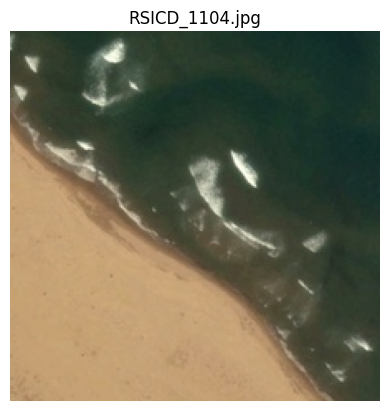

Human-written Captions:
  1. yellow beach is near a piece of green ocean with some small white waves .
  2. yellow beach is near a piece of green ocean with some small white waves .
  3. yellow beach is near a piece of green ocean with some small white waves .
  4. yellow beach is near a piece of green ocean with some small white waves .
  5. yellow beach is near a piece of green ocean with some small white waves .

CLIP-selected Best Caption:
  yellow beach is near a piece of green ocean with some small white waves .

----------------------------------------------------------------------------------------------------


In [10]:
sampled_rows = df.sample(n=3)

for _, row in sampled_rows.iterrows():
    img_path = image_dir / row['image']
    captions = [row[f"caption_{i}"] for i in range(1, 6)]
    best_caption = clip_best_caption(str(img_path), captions)

    # Display image
    image = Image.open(img_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(row['image'])
    plt.show()

    # Display all captions
    print("Human-written Captions:")
    for i, cap in enumerate(captions, 1):
        print(f"  {i}. {cap}")

    # Highlight best
    print(f"\nCLIP-selected Best Caption:\n  {best_caption}\n")
    print("-" * 100)

In [11]:
def select_longest_caption(row):
    captions = [row[f"caption_{i}"] for i in range(1, 6)]
    longest = max(captions, key=lambda x: len(x.split()))
    return longest

df["caption"] = df.apply(select_longest_caption, axis=1)

In [12]:
df.head()

,source,split,image,caption_1,caption_2,caption_3,caption_4,caption_5,caption
0,NWPU,test,NWPU_31430.jpg,A gray plane on the runway and the lawn beside .,A grey plane is on the runway by the lawn .,There is an airplane on the runway with a larg...,A plane is parked on the runway next to the gr...,There is a plane on the runway beside the grass .,There is an airplane on the runway with a larg...
1,NWPU,test,NWPU_31431.jpg,Three small planes parked in a line on the air...,"There are four aircraft on the open ground, Th...",There are many planes of different sizes in a ...,Four planes are parked on the runway .,Four planes of different sizes were on the mar...,"There are four aircraft on the open ground, Th..."
2,NWPU,test,NWPU_31432.jpg,A plane parked in a line on the airport with s...,A white plane was parked on the instruction li...,An airplane parked in an open area with many c...,A plane is parked on the open space .,There is 1 plane on the ground marked .,An airplane parked in an open area with many c...
3,NWPU,test,NWPU_31433.jpg,A small plane and a big plane parked next to b...,A white plane and a gray plane parked at the b...,Two planes of different sizes are neatly parke...,A large plane and a small plane are parked nea...,Two planes are on the marked ground .,A white plane and a gray plane parked at the b...
4,NWPU,test,NWPU_31434.jpg,Two planes parked next to boarding bridges .,Two aircraft were parked at the departure gates .,Two planes of different sizes are neatly parke...,Two planes are parked next to the terminal .,Two planes are on the marked ground .,Two planes of different sizes are neatly parke...


In [13]:
split_counts = df["split"].value_counts()
split_percent = df["split"].value_counts(normalize=True) * 100

split_info = pd.DataFrame({
    "Count": split_counts,
    "Percentage": split_percent.round(2)
})

print(split_info)

       Count  Percentage
split                   
train  35614       79.99
test    4454       10.00
val     4453       10.00


# Downloading Paligemma Weights

Here we will be downloading the paligemma weights available in the kagglehub.

Transformers PaliGemma 2 3B weights, pre-trained with 224*224 input images and 128 token input/output text sequences. The models are available in bfloat16 for fine-tuning.

In [14]:
from transformers import AutoProcessor, AutoModelForVision2Seq
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained(model_path)
model = AutoModelForVision2Seq.from_pretrained(model_path, torch_dtype=torch.float16).to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

NOTE: PaliGemma 2 checkpoints are intended for use as a base for fine-tuning to your specific use cases.

We will assume that your fine-tuned model is available in your environment at the location indicated by path.

First, import Transformers and set up the model and processor.

In [15]:
def read_image(path):
    image = Image.open(path).convert("RGB")
    image = np.array(image)
    if image.shape[-1] == 4:
        image = image[:, :, :3]
    return image

In [16]:
def generate_caption_from_array(image_array, prompt="<image> describe this image in detail", max_tokens=50):
    inputs = processor(
        text=prompt,
        images=image_array,
        padding="longest",
        do_convert_rgb=True,
        return_tensors="pt"
    ).to(device)

    inputs = inputs.to(dtype=model.dtype)

    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=max_tokens)

    return processor.decode(output[0], skip_special_tokens=True)

In [17]:
def run_inference(df_subset, image_dir, output_csv_path, max_items=None, prompt="<image> describe this image in detail", max_tokens=50):
    results = []
    
    if max_items:
        df_subset = df_subset.sample(n=max_items, random_state=42).reset_index(drop=True)
    else:
        df_subset = df_subset.reset_index(drop=True)

    for idx in tqdm(range(len(df_subset)), desc="Generating captions"):
        row = df_subset.iloc[idx]
        img_path = image_dir / row["image"]
        
        if not img_path.exists():
            tqdm.write(f"Missing image: {img_path.name}")
            continue

        image_array = read_image(img_path)
        generated_caption = generate_caption_from_array(image_array, prompt=prompt, max_tokens=max_tokens)

        results.append({
            "image": row["image"],
            "generated_caption": generated_caption,
            "reference_caption": row["caption"]
        })

    result_df = pd.DataFrame(results)
    result_df.to_csv(output_csv_path, index=False)
    return result_df

In [ ]:
train_df = df[df["split"] == "train"]

train_preds = run_inference(
    train_df,
    image_dir,
    output_csv_path="/kaggle/working/train_preds.csv",
    prompt="<image> describe this image in detail",
    max_tokens=40
)